In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json
from pprint import pprint

In [3]:
import json

In [4]:
import re

In [5]:
import numpy as np

In [6]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [8]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.keys = set(keys)
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            split = line.strip().split('=')
            if len(split)==2:
                query = split[0]
                value = float(split[1])
                if query in self.keys:
                    self.matches[query].append(value)
            line = next(self.file, None)
        return self.matches

In [9]:
tasks = [
    ('atac_region', 'gene'),
    ('gene', 'atac_region'),
    ('gene', 'protein_name'),
    ('protein_name', 'gene'),
]

In [10]:
base_keys = [
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

keys = []
for key in base_keys:
    for task in tasks:
        keys.append(f'{key} {task}')

In [11]:
keys += [
    'Outer step',
]

In [12]:
readers = {}
matches = {}

#### Timestamp of run

In [55]:
timestamps = [
    '20211102-1454',
    '20211102-1455',
    '20211103-0958',
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [56]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)
        matches = readers[file].grab()

## All Latest Validation Losses

In [183]:
for tmstp in timestamps:
    file = f'logs/train_earl_{tmstp}.log'
    matches = readers[file].grab()
    print(tmstp)
    for task in tasks:
        validation_loss = matches[f'validation prediction loss {task}']
        print(task, ' '.join([f'{loss:.3f}' for loss in validation_loss[-7:]]))
    print('--')

20211102-1454
('atac_region', 'gene') 0.333 0.375 0.380 0.409 0.467 0.341 0.377
('gene', 'atac_region') 0.056 0.089 0.057 0.079 0.052 0.083 0.099
('gene', 'protein_name') 0.442 0.526 0.343 0.373 0.320 0.305 0.221
('protein_name', 'gene') 0.306 0.249 0.226 0.265 0.481 0.280 0.411
--
20211102-1455
('atac_region', 'gene') 0.335 0.360 0.333 0.429 0.322 0.364 0.308
('gene', 'atac_region') 0.039 0.081 0.049 0.051 0.054 0.058 0.101
('gene', 'protein_name') 0.451 0.423 0.337 0.372 0.308 0.425 0.334
('protein_name', 'gene') 0.276 0.370 0.372 0.403 0.321 0.287 0.293
--
20211103-0958
('atac_region', 'gene') 0.277 0.233 0.255 0.313 0.282 0.403 0.237
('gene', 'atac_region') 0.111 0.104 0.060 0.132 0.163 0.083 0.080
('gene', 'protein_name') 0.616 0.521 0.521 0.578 0.563 0.431 0.482
('protein_name', 'gene') 0.324 0.276 0.297 0.431 0.271 0.311 0.239
--


## Select File

In [248]:
idx = 1

## Get matching log lines

In [249]:
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [250]:
pprint(json.load(open(f'logs/earl_params_{timestamps[idx]}.json')))

{'atac_ones_weight': 1,
 'checkpoint': 40,
 'device': 'cuda:2',
 'gene_ones_weight': 1,
 'inner_lr': 0.01,
 'inner_steps': 5,
 'layers': [['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}]],
 'mode': 'reptile',
 'n_steps': 10000,
 'out_mlp': {'bias': True,
             'dim_in': 128,
             'dim_inner': 512,
             'dim_out': 1,
             'num_layers': 3},
 'outer_lr': 0.1,
 'target_heads': True,
 'train_batch_size': 10,
 'validation_batch_size': 10}


## Current Step

In [251]:
batch = matches['Outer step'][-1]
batch

2166.0

## Training loss

('atac_region', 'gene') 0.2919
('gene', 'atac_region') 0.0770
('gene', 'protein_name') 0.3635
('protein_name', 'gene') 0.2880


<Figure size 1080x720 with 0 Axes>

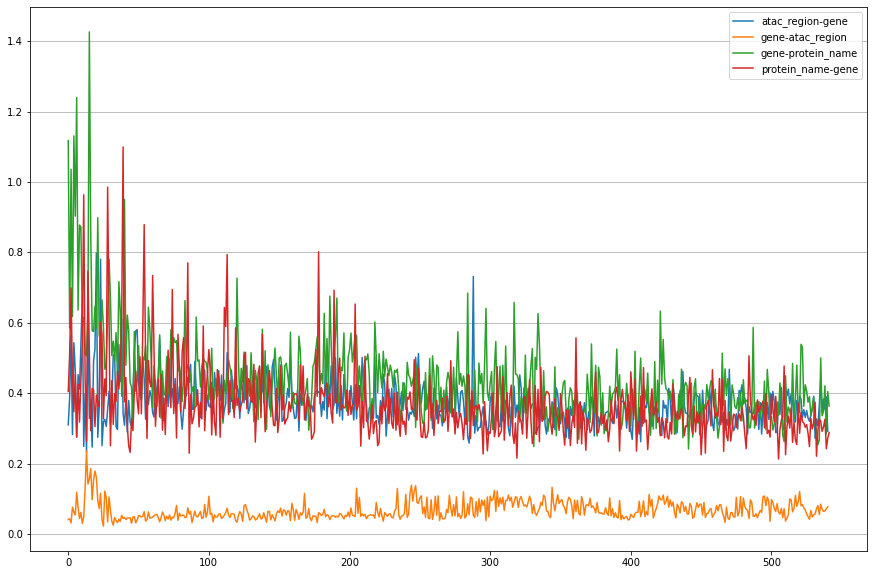

In [252]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(training_loss[0:], label=f'{task[0]}-{task[1]}')
    print(task, f'{training_loss[-1]:.4f}')
_=ax.legend()


('atac_region', 'gene') 0.29187484830617905
('gene', 'atac_region') 0.07701455131173135
('gene', 'protein_name') 0.36347181499004366
('protein_name', 'gene') 0.2880294069647789


<Figure size 1080x720 with 0 Axes>

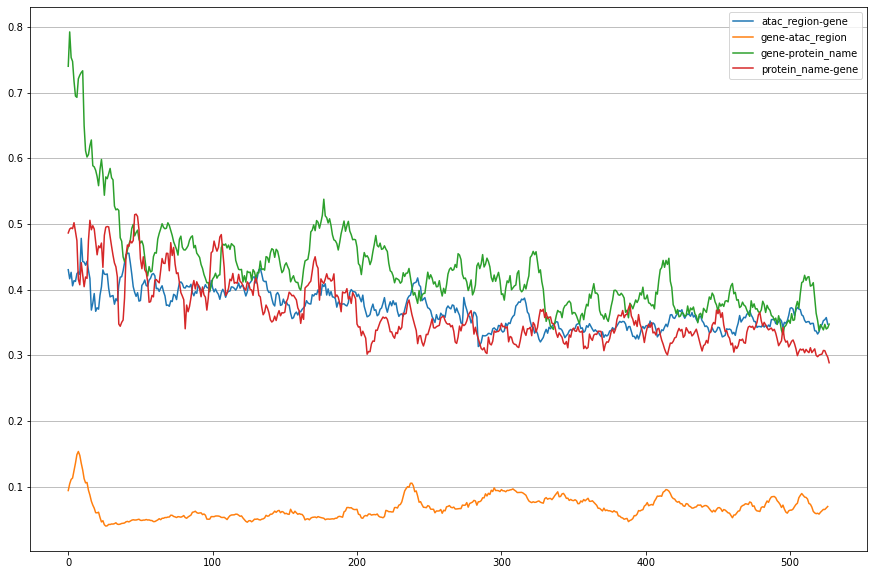

In [253]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(moving_average(training_loss[5:],10), label=f'{task[0]}-{task[1]}')
    print(task, training_loss[-1])
_=ax.legend()


## Validation Loss

('atac_region', 'gene') 0.34896876513957975
('gene', 'atac_region') 0.0799974225461483
('gene', 'protein_name') 0.4490869298577308
('protein_name', 'gene') 0.2889498263597488


<Figure size 1080x720 with 0 Axes>

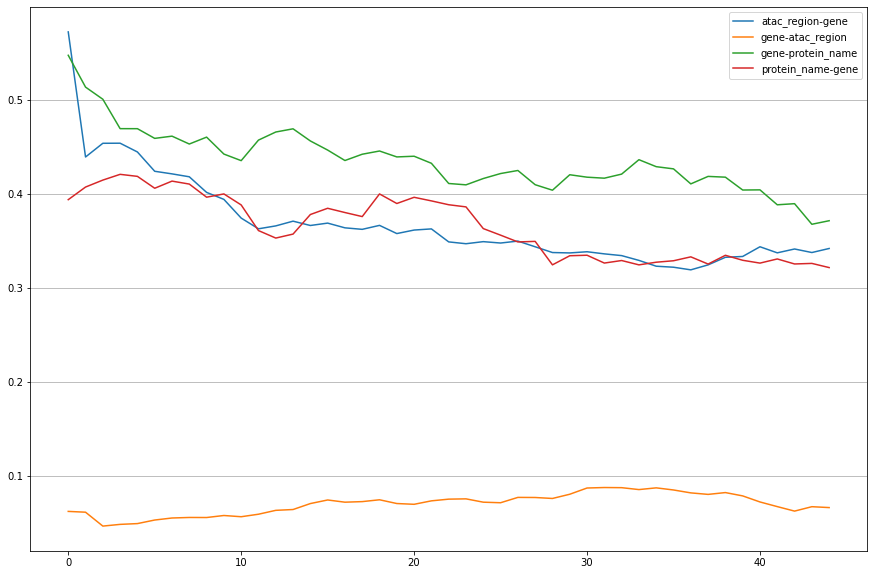

In [254]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    validation_loss = matches[f'validation prediction loss {task}']
    _=ax.plot(moving_average(validation_loss,10), label=f'{task[0]}-{task[1]}')
#     _=ax.plot(validation_loss, label=f'{task[0]}-{task[1]}')
    print(task, validation_loss[-1])
_=ax.legend()

## Sample predictions

In [255]:
import time

In [256]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

for line in prediction_file:
    print(line.strip(), flush=True)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Task: ('protein_name', 'gene')
--------------------------------------------------------------------------------
batch 2159 0      pred,y:   0.965 0.000
batch 2159 1      pred,y:   0.000 0.000
batch 2159 2      pred,y:   0.000 0.000
batch 2159 3      pred,y:   0.000 0.000
batch 2159 4      pred,y:   0.000 0.000
batch 2159 5      pred,y:   0.000 0.000
batch 2159 6      pred,y:   0.000 0.000
batch 2159 7      pred,y:   0.000 0.000
batch 2159 8      pred,y:   1.400 0.000
batch 2159 9      pred,y:   0.000 0.000
batch 2159 10     pred,y:   0.000 0.000
batch 2159 11     pred,y:   0.994 0.000
batch 2159 12     pred,y:   0.000 0.000
batch 2159 13     pred,y:   0.000 0.000
batch 2159 14     pred,y:   1.166 0.555
batch 2159 15     pred,y:   0.000 0.000
batch 2159 16     pred,y:   0.000 0.000
batch 2159 17     pred,y:   0.000 0.555
batch 2159 18     pred,y:   0.917 0.000
batch 2159 19     pred,y:   1.143 0.555
batch 2159 20     pred,y:   0.000 0.909
batch 2159 21     pred,y:   0.000 0.555
batch 21

batch 2159 203    pred,y:   0.000 0.000
batch 2159 204    pred,y:   0.980 0.000
batch 2159 205    pred,y:   0.000 0.555
batch 2159 206    pred,y:   0.000 0.000
batch 2159 207    pred,y:   0.000 0.000
batch 2159 208    pred,y:   0.000 0.000
batch 2159 209    pred,y:   0.000 0.000
batch 2159 210    pred,y:   0.000 0.000
batch 2159 211    pred,y:   0.000 0.000
batch 2159 212    pred,y:   0.000 0.000
batch 2159 213    pred,y:   0.000 0.000
batch 2159 214    pred,y:   0.846 0.000
batch 2159 215    pred,y:   0.000 0.000
batch 2159 216    pred,y:   0.000 0.000
batch 2159 217    pred,y:   0.000 0.909
batch 2159 218    pred,y:   0.917 0.000
batch 2159 219    pred,y:   0.000 0.000
batch 2159 220    pred,y:   0.000 0.000
batch 2159 221    pred,y:   0.000 0.000
batch 2159 222    pred,y:   0.000 0.909
batch 2159 223    pred,y:   0.000 0.555
batch 2159 224    pred,y:   0.000 0.000
batch 2159 225    pred,y:   0.000 0.000
batch 2159 226    pred,y:   0.000 0.000
batch 2159 227    pred,y:   0.000 0.000


batch 2159 103    pred,y:   0.000 1.621
batch 2159 104    pred,y:   0.000 0.941
batch 2159 105    pred,y:   0.680 0.811
batch 2159 106    pred,y:   0.000 0.000
batch 2159 107    pred,y:   0.686 0.272
batch 2159 108    pred,y:   0.621 1.842
batch 2159 109    pred,y:   0.652 0.485
batch 2159 110    pred,y:   0.000 0.000
batch 2159 111    pred,y:   0.000 0.485
batch 2159 112    pred,y:   0.828 0.941
batch 2159 113    pred,y:   1.385 2.308
batch 2159 114    pred,y:   1.104 0.272
batch 2159 115    pred,y:   1.130 0.811
batch 2159 116    pred,y:   1.528 2.063
batch 2159 117    pred,y:   0.000 2.140
batch 2159 118    pred,y:   0.000 0.272
batch 2159 119    pred,y:   0.431 0.000
batch 2159 120    pred,y:   0.932 1.558
batch 2159 121    pred,y:   1.312 2.712
batch 2159 122    pred,y:   0.513 0.000
batch 2159 123    pred,y:   0.551 0.000
batch 2159 124    pred,y:   1.439 1.842
batch 2159 125    pred,y:   0.000 0.272
batch 2159 126    pred,y:   0.955 0.661
batch 2159 127    pred,y:   0.849 0.661


batch 2159 170    pred,y:   0.000 0.000
batch 2159 171    pred,y:   0.000 0.000
batch 2159 172    pred,y:   0.000 0.000
batch 2159 173    pred,y:   0.000 0.000
batch 2159 174    pred,y:   0.000 0.000
batch 2159 175    pred,y:   1.485 0.000
batch 2159 176    pred,y:   0.000 0.000
batch 2159 177    pred,y:   0.000 0.000
batch 2159 178    pred,y:   0.000 1.133
batch 2159 179    pred,y:   0.000 0.000
batch 2159 180    pred,y:   0.000 0.000
batch 2159 181    pred,y:   0.000 0.000
batch 2159 182    pred,y:   0.000 0.000
batch 2159 183    pred,y:   0.000 0.000
batch 2159 184    pred,y:   1.155 0.000
batch 2159 185    pred,y:   0.000 0.000
batch 2159 186    pred,y:   0.000 1.133
batch 2159 187    pred,y:   0.000 0.000
batch 2159 188    pred,y:   0.000 0.000
batch 2159 189    pred,y:   0.000 0.000
batch 2159 190    pred,y:   1.212 0.000
batch 2159 191    pred,y:   0.000 0.000
batch 2159 192    pred,y:   0.000 0.000
batch 2159 193    pred,y:   0.000 0.000
batch 2159 194    pred,y:   0.000 0.000


batch 2159 71     pred,y:   0.045 0.000
batch 2159 72     pred,y:   0.050 0.000
batch 2159 73     pred,y:   0.059 0.000
batch 2159 74     pred,y:   0.062 0.000
batch 2159 75     pred,y:   0.038 0.000
batch 2159 76     pred,y:   0.041 0.000
batch 2159 77     pred,y:   0.039 1.000
batch 2159 78     pred,y:   0.041 1.000
batch 2159 79     pred,y:   0.035 0.000
batch 2159 80     pred,y:   0.038 0.000
batch 2159 81     pred,y:   0.038 0.000
batch 2159 82     pred,y:   0.042 0.000
batch 2159 83     pred,y:   0.041 0.000
batch 2159 84     pred,y:   0.041 0.000
batch 2159 85     pred,y:   0.207 0.000
batch 2159 86     pred,y:   0.041 0.000
batch 2159 87     pred,y:   0.038 1.000
batch 2159 88     pred,y:   0.026 0.000
batch 2159 89     pred,y:   0.041 0.000
batch 2159 90     pred,y:   0.029 0.000
batch 2159 91     pred,y:   0.033 0.000
batch 2159 92     pred,y:   0.047 0.000
batch 2159 93     pred,y:   0.040 0.000
batch 2159 94     pred,y:   0.030 0.000
batch 2159 95     pred,y:   0.038 0.000


batch 2159 276    pred,y:   0.078 0.000
batch 2159 277    pred,y:   0.041 0.000
batch 2159 278    pred,y:   0.040 0.000
batch 2159 279    pred,y:   0.044 0.000
batch 2159 280    pred,y:   0.030 0.000
batch 2159 281    pred,y:   0.040 0.000
batch 2159 282    pred,y:   0.038 0.000
batch 2159 283    pred,y:   0.212 0.000
batch 2159 284    pred,y:   0.040 0.000
batch 2159 285    pred,y:   0.040 0.000
batch 2159 286    pred,y:   0.043 0.000
batch 2159 287    pred,y:   0.041 0.000
batch 2159 288    pred,y:   0.046 0.000
batch 2159 289    pred,y:   0.050 0.000
batch 2159 290    pred,y:   0.039 0.000
batch 2159 291    pred,y:   0.058 0.000
batch 2159 292    pred,y:   0.041 0.000
batch 2159 293    pred,y:   0.041 0.000
batch 2159 294    pred,y:   0.041 0.000
batch 2159 295    pred,y:   0.039 0.000
batch 2159 296    pred,y:   0.037 0.000
batch 2159 297    pred,y:   0.058 0.000
batch 2159 298    pred,y:   0.041 0.000
batch 2159 299    pred,y:   0.041 1.000
